# Homoclinic Connections Search

We demonstrate the method from Cleary & Page (2023) to compute dynamical homoclinic connections between relative equilibria of the point vortex model.

### Initial Imports

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit
import VorticesMotion as vm
import loss_functions as lf
import velocity_transforms as vt
import stability as stab
import hungarian as hun
import utils
import optax
from functools import partial

import pickle
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)

/opt/homebrew/Caskroom/miniforge/base/envs/jax/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


### 1) Read in all the Relative Equilibria

In [2]:
n = 4

# read in all equilibria with n vortices

eq_in_file = 'data/n'+str(n)

with open(eq_in_file, 'rb') as f:
    full_data = pickle.load(f)

equilibria = full_data['params']
delta_f = full_data['delta_f']

gammas = jnp.ones(n)
ind = utils.indices(n)

# order the REQ by \Delta f
sorted_ind = jnp.argsort(delta_f)
equilibria = equilibria[sorted_ind]
delta_f = delta_f[sorted_ind]

# choose which REQ to use as endpoints of the connection
eq = equilibria[2]

### 2) Parameters

In [3]:
# Set the parameters for the candidate generation

Nt = 100000                           # total number of time steps to search for candidates
inner_steps = 1000                    
outer_steps = int(Nt / inner_steps)
dt = 0.001                            # time step
eps = 1e-5                            # fixed size of perturbation parameter
loss_thres = 0.1                      # threshold on loss for candidate

omega = jnp.pi*0.1                    # desired rate of rotation
eq = vt.scale_to_omega(eq, gammas, omega, n, ind)     # scale the REQ to this omega

### 3) Stability Analysis

In [4]:
# Compute the unstable directions of the REQ

_, _, unstable_eigenvectors, _ = stab.stability_directions(eq)
N_U = len(unstable_eigenvectors)

print(f'Dimension of Unstable Manifold = {N_U}')

Dimension of Unstable Manifold = 2


In [5]:
# For illustration purposes, choose one guess for the vector of constants, c
cs = jnp.array([1., 1.])

# perturb slightly along unstable manifold
cand_state = eq + eps * jnp.real(jnp.dot(cs, unstable_eigenvectors)) / jnp.linalg.norm(jnp.real(jnp.dot(cs, unstable_eigenvectors)))

# centre on centre of vorticity and create system
cand_state = utils.centre_on_com(cand_state, gammas)
system = vm.Vortices(cand_state, gammas)

### 4) Create the Gaussian Grid-Based Observable

In [6]:
# set up the grid
x_min = jnp.min(eq)
x_max = jnp.max(eq)
x_min_abs = jnp.abs(x_min)
x_max_abs = jnp.abs(x_max)
x_min -= 0.5 * x_min_abs
x_max += 0.5 * x_max_abs

grid_size = 64
x = jnp.linspace(x_min,x_max,grid_size)
y = x
X,Y = np.meshgrid(x,y)
grid = np.empty(X.shape + (2,))
grid[:, :, 0] = X; grid[:, :, 1] = Y

# smear the states with an appropriately chosen covariance matrix

cov = 0.01*((x_max - x_min))**2/float(n)

# discretise the angle
N_angles = 1000
thetas = jnp.linspace(0, 2.*jnp.pi, N_angles, endpoint = False)

# pre create the rotated grids and store in memory

grids = np.zeros((N_angles, grid_size*grid_size))

for k in range(N_angles):        # compute grids for rotated orginal equilibrium
    temp = utils._rotate(eq, thetas[k])
    grids[k] = lf.gaussian_smear(temp, grid, cov).flatten()

### 5) Generate the Trajectory and Compute Gaussian Loss

In [7]:
min_distances = np.zeros(outer_steps)
min_angles = np.zeros(outer_steps)
times = np.linspace(0, Nt, outer_steps, endpoint=False)

# now generate the trajectory and the visualisation data

for i in range(outer_steps):

    smeared_state = lf.gaussian_smear(system.state, grid, cov).flatten()

    all_distances = jnp.mean(jnp.square(grids - smeared_state), axis = -1)

    # minimise over angles for each equilibrium
    min_inds = jnp.argmin(all_distances)
    min_distances[i] = all_distances[min_inds]
    min_angles[i] = thetas[min_inds]

    system.rk2_finalN(dt, inner_steps)

### 6) Plot the Gaussian Loss over the Trajectory

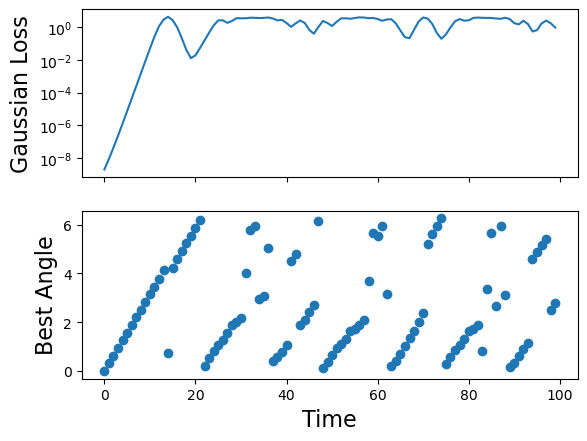

In [8]:
fig, (ax1, ax2) = plt.subplots(2, sharex = True)
ax1.plot(times*dt, min_distances)
ax2.scatter(times*dt, min_angles)
ax2.set_xlabel('Time', fontsize=16)
ax1.set_ylabel('Gaussian Loss', fontsize=16)
ax2.set_ylabel('Best Angle', fontsize=16)
ax1.set_yscale('log')
plt.show()

### 8) Extract the Connection Candidates if any

In [9]:
rfa_bool = np.array(min_distances < loss_thres).nonzero()
times_good = np.array(times[rfa_bool], dtype=int)
angles_good = min_angles[rfa_bool]

# let's take the longest candidate
time_cand = times_good[-1]
angle_cand = angles_good[-1]

print(f'Number of time steps of connection candidate = {time_cand}')
print(f'Optimum angle for connection candidate = {angle_cand}')

Number of time steps of connection candidate = 21000
Optimum angle for connection candidate = 6.176371156957534


### 9) Set up the AD optimisation

In [10]:
# ----- set the parameters for the AD optimisation -------------
Nt = time_cand          # starting trajectory length
opt_N_per_Nt = 1001     # optimisation steps per epoch
Nt_bumps = 10           # number of epochs
bump_size = 0.01        # factor we increase the length of the trajectory Nt each epoch
Nt_bump = int(Nt * bump_size)    # number of time steps each epoch is increased
print_cycle = 100       # how often to print the optimisation loss

starting_Nt_tol = -3                # starting loss function tolerance
target_tol = -6                     # target loss function tolerance
tols = np.logspace(target_tol, starting_Nt_tol, Nt_bumps)[::-1]     # logarithmically space out the intermediate tolerances

# set a different initial learning rate for the vector of constants and the rotation angle
param_labels = ['pert', 'theta_symm'] # trainable parameters
params = [cs, 0.]                     # trainable parameters
pert_learning_rate = 1e-3
symm_learning_rate = 1e-2



# ----------- Update function for the vector of constants and rotation angle ------
@partial(jit, static_argnums=(3))
def gradfn2(params: jnp.array, eq: jnp.array, gammas: jnp.array, Nt: int, unstable_eigenvectors: jnp.array, eps: float, eq_final: jnp.array):
    return jax.value_and_grad(lf.homoconnect)(params, eq, gammas, Nt, unstable_eigenvectors, eps, eq_final)
  
@partial(jit, static_argnums=(4,5))
def updatefn2(params, eq, gammas, opt_state, optimizer, Nt, unstable_eigenvectors, eps, eq_final):

    loss, grads = gradfn2(params, eq, gammas, Nt, unstable_eigenvectors, eps, eq_final)

    updates, opt_state = optimizer.update(grads, opt_state)

    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

### 10) Hungarian algorithm to permute the final copy of the REQ

In [11]:
# compute the final state on the candidate trajectory
final_state = vm._rk2_finalN(cand_state, gammas, ind, time_cand, dt)

# reduce the rotational symmetry with the symmetry angle from the candidate generation
eq_final = utils._rotate(eq, angle_cand)

# ensure that the trajectory and the final equilibrium are on a constant energy surface
H_traj = vm._return_H(final_state, gammas, n)
H_eq = vm._return_H(eq_final, gammas, n)
delta = utils.compute_H_scaling(H_traj, H_eq, n)
eq_final = eq_final * delta

# reduce the permutation symmetry
eq_final, _ = hun.hungarian_sorting(eq_final, final_state)

### 11) Perform the AD Optimisation with the Euclidean Loss

In [12]:
# loop over the number of epochs
for j in range(Nt_bumps):
    
    # decrease the tolerance and increase the integration time
    Nt_tol = tols[j]
    Nt += Nt_bump
    
    print('---------Current Parameters-----------')
    print(f'{j} / {Nt_bumps}')
    print('Nt = ', Nt)
    print('Tolerance = ', Nt_tol)
    print('--------------------------------------')
    
    optimizer = optax.multi_transform(
            {'pert': optax.adam(pert_learning_rate), 'theta_symm': optax.adam(symm_learning_rate)},
            param_labels)
    opt_state = optimizer.init(params)
    
    for k in range(opt_N_per_Nt):

        params, opt_state, loss = updatefn2(params, eq, gammas, opt_state, optimizer, Nt, unstable_eigenvectors, eps, eq_final)

        if k%print_cycle == 0:
            print(params)
            print(k, ": Loss = ", loss)

        if loss < Nt_tol:
            print('Euclidean converged! :)')
            break
        
    if loss > Nt_tol:
        print('Not converged at this bump so stop bumping :(')
        break

---------Current Parameters-----------
0 / 10
Nt =  21210
Tolerance =  0.001
--------------------------------------


/opt/homebrew/Caskroom/miniforge/base/envs/jax/lib/python3.10/site-packages/optax/_src/combine.py:129: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  label_set = set(jax.tree_leaves(labels))


[DeviceArray([1.00099999, 0.99900001], dtype=float64), DeviceArray(-0.01, dtype=float64)]
0 : Loss =  0.003923323976499544
Euclidean converged! :)
---------Current Parameters-----------
1 / 10
Nt =  21420
Tolerance =  0.00046415888336127773
--------------------------------------
[DeviceArray([1.007999  , 0.99199871], dtype=float64), DeviceArray(-0.07452592, dtype=float64)]
0 : Loss =  0.00427200795995251
[DeviceArray([1.10552855, 0.89101514], dtype=float64), DeviceArray(-0.12925664, dtype=float64)]
100 : Loss =  0.0008545686507333126
[DeviceArray([1.19435788, 0.78961198], dtype=float64), DeviceArray(-0.12945081, dtype=float64)]
200 : Loss =  0.0006577697224595797
[DeviceArray([1.27195681, 0.69119515], dtype=float64), DeviceArray(-0.12945203, dtype=float64)]
300 : Loss =  0.0004917165826137946
Euclidean converged! :)
---------Current Parameters-----------
2 / 10
Nt =  21630
Tolerance =  0.00021544346900318823
--------------------------------------
[DeviceArray([1.28632825, 0.67205744], 

### 12) Plot the Converged Connection

In [13]:
# Extract the converged trainable parameters
conv_cs = params[0]
conv_theta_symm = params[1]

print(f'Converged Vector of Constants c = {conv_cs}')
  
# Converged initial state on connection
conv_init_state = eq + eps * jnp.real(jnp.dot(conv_cs, unstable_eigenvectors)) / jnp.linalg.norm(jnp.real(jnp.dot(conv_cs, unstable_eigenvectors)))

# Converged final state on connection
final_state = vm._rk2_finalN(conv_init_state, gammas, ind, Nt, dt)
  
# Reduce the rotational symmetry and ensure the final REQ is on the same energy surface as the converged trajectory
eq_final = utils._rotate(eq_final, -1.*conv_theta_symm)

H = vm._return_H(eq_final,gammas,n)
H_traj = vm._return_H(final_state,gammas,n)
delta = utils.compute_H_scaling(H_traj, H, n)
eq_final = eq_final * delta

Converged Vector of Constants c = [1.88628491 0.00194088]


<IPython.core.display.Javascript object>


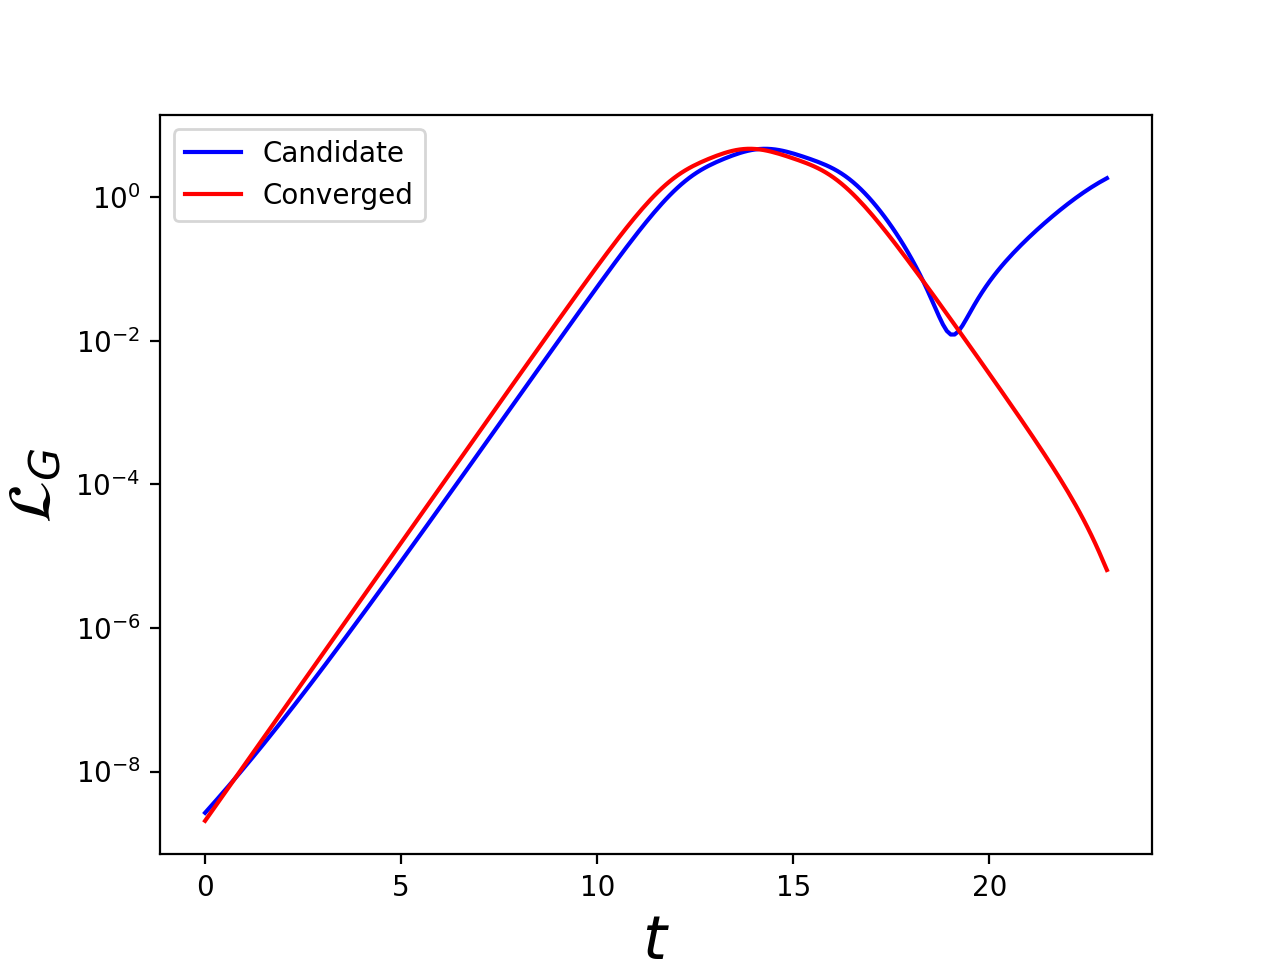

In [14]:
# plot how the Gaussian loss decreased over the converged trajectory
%matplotlib notebook

inner_steps = 100
outer_steps = int(Nt / inner_steps + 1)
    
loss_cand = np.zeros(outer_steps)
loss_conv = np.zeros(outer_steps)

# create systems for the candidate and converged trajectories
system_cand = vm.Vortices(cand_state, gammas)
system_conv = vm.Vortices(conv_init_state, gammas)

# grid observable for REQ
eq_grid = lf.gaussian_smear(utils._pullback(eq_final, 0), grid, cov).flatten()

fig, ax = plt.subplots(1)

for i in range(outer_steps):
    
    temp_cand = utils._pullback(system_cand.state, 0)
    temp_conv = utils._pullback(system_conv.state, 0)

    smeared_state_cand = lf.gaussian_smear(temp_cand, grid, cov).flatten()
    smeared_state_conv = lf.gaussian_smear(temp_conv, grid, cov).flatten()

    loss_cand[i] = jnp.mean(jnp.square(eq_grid - smeared_state_cand), axis = -1)
    loss_conv[i] = jnp.mean(jnp.square(eq_grid - smeared_state_conv), axis = -1)

    system_cand.rk2_finalN(dt, inner_steps)
    system_conv.rk2_finalN(dt, inner_steps)

times = np.linspace(0, Nt, outer_steps, endpoint=False)
print_cycle = 1

ax.plot(times[::print_cycle]*0.001, loss_cand[::print_cycle], color='b', label='Candidate')#, c='w', marker='s', markeredgecolor='b', markersize=6)
ax.plot(times[::print_cycle]*0.001, loss_conv[::print_cycle], color='r', label='Converged')
ax.set_xlabel('$t$', fontsize=22)
ax.set_ylabel('$\\mathcal{L}_{G}$', fontsize=22)
ax.set_yscale('log')
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


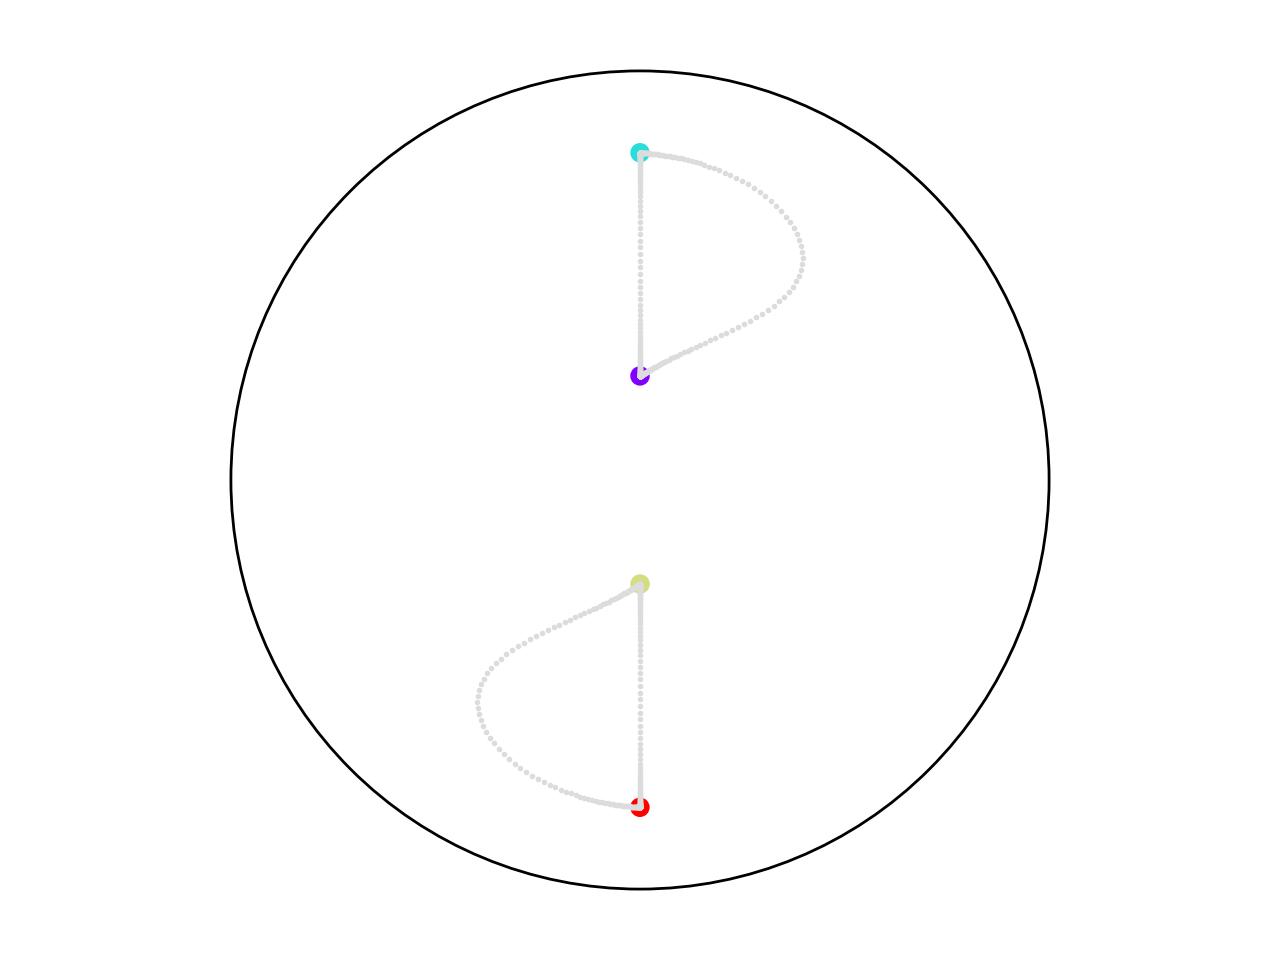

In [15]:
# animate the connection in a symmetry reduced frame

import matplotlib.animation as animation

system = vm.Vortices(utils._pullback(conv_init_state,0), gammas)

figanim, axanim = plt.subplots(1)
axanim.set_box_aspect(1)
r_max = jnp.max(jnp.sqrt(conv_init_state[:n]**2 + conv_init_state[n:]**2))
circle = plt.Circle((0, 0), r_max*1.25, fill=False, color='black')
axanim.add_patch(circle)
axanim.set_axis_off()
axanim.set_box_aspect(1)

figanim.tight_layout()

colors = plt.cm.rainbow(np.linspace(0, 1, n))
scat0 = axanim.scatter(system.state[:n], system.state[n:], c=colors)
saved_states = []

def animate(i):
    system.rk2_finalN(dt, 100)
    temp = utils._pullback(system.state, 0)
    axanim.scatter(temp[:n], temp[n:], s=1 ,c='gainsboro')
    scat0.set_offsets(np.c_[temp[:n], temp[n:]])
    saved_states.append(temp)
    return scat0, 
    
    
animation.FuncAnimation(figanim, animate, frames = int(Nt/100 + 1), repeat=False, interval = 1)